# Pseudospectral tutorial, part 2
## UNCW, March 2018


A gentle stroll through pseudospectral methods: solving $\partial_t \zeta + u\partial_x\zeta + v\partial_y\zeta = \nu \nabla^2\zeta$, where $\zeta = \nabla^2\psi$, $u=-\partial_y\psi$, and $v=\partial_x\psi$.



First load the package for plotting.

In [19]:
using PyPlot

We create the physical grid $x$, $y$ (as in "Part 1" notebook). Also, we create the wavenumber grid. We take $L_x=L_y=2\pi$.

In [25]:
nx, ny = 64, 64 # number of grid points
Lx, Ly = 2.0*pi, 2.0*pi      # size of the domain in each direction

# constructing the physical grid (x,y)
dx, dy = Lx/nx, Ly/ny
 x = 0:dx:Lx-dx
 y = 0:dy:Ly-dy

X  = zeros(nx,ny)
Y  = zeros(nx,ny)
for j in 1:ny, i in 1:nx
     X[i, j] = x[i]
     Y[i, j] = y[j]
end

# constructing the wavenumber grid (k,l)
k  = 2.0*pi/Lx * [0:nx/2; -nx/2+1:-1];
l  = 2.0*pi/Ly * [0:ny/2; -ny/2+1:-1];

K = zeros(nx, ny)
L = zeros(nx, ny)
for j in 1:ny, i in 1:nx
    K[i, j] = k[i]
    L[i, j] = l[j]
end

ksq = K.^2 + L.^2

invksq = 1./ksq
invksq[1,1] = 1;

Let's define some parameters.

In [26]:
nu = 8.0e-5       # diffusion coefficient
dt = 0.02         # the time stem
tfin = 250         # the final time
nstep  = Int(tfin/dt) + 1;  # the total number of time steps

t = 0:dt:tfin;

Prescribe an initial condition for $\zeta$ and plot it.

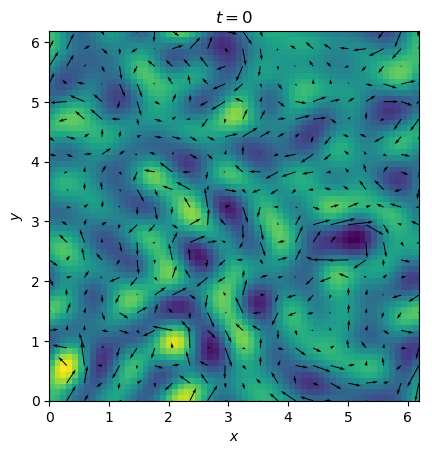

In [27]:
zeta0 = randn(nx, ny)
zetah = fft(zeta0)
zetah[1, 1] = 0
zetah[ K.^2+L.^2.>(1*nx/8)^2 ] .= 0
zetah[ K.^2+L.^2.<(3)^2 ] .= 0
zeta0 = real(ifft(zetah))
psih = -invksq.*zetah           # calculate \hat{ψ}
zeta =  real(ifft(zetah))       # calculate ζ(x,y,t)
u = real(ifft(-im*L.*psih))     # calculate zonal velocity u(x,y,t)
v = real(ifft(+im*K.*psih))     # calculate meridional velocity v(x,y,t)


# xc1, yc1 = 3*pi/2, 3*pi/2
# sx1, sy1 = 0.5, 0.7
# xc2, yc2 = pi/2, pi/2
# sx2, sy2 = 0.7, 0.5
# zeta0 = .1*exp.(-(X-xc1).^2/sx1^2-(Y-yc1).^2/sy1^2) -  .1exp.(-(X-xc2).^2/sx2^2-(Y-yc2).^2/sy2^2)
# zetah = fft(zeta0)
# zetah[1, 1] = 0
# zetah[ K.^2+L.^2.>(1*nx/3)^2 ] .= 0
# zeta0 = real(ifft(zetah))


time = 0
nc=3
figure(1)
pcolormesh(X, Y, zeta0)
quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
xlabel(L"$x$")
ylabel(L"$y$")
title("\$t = $time \$")
draw()
axis("square")
# colorbar();

Time-step $\zeta$ forward for `nstep` times. Notice that we use the conservative form: $\nabla\cdot(\mathbf{u}\zeta)$ instead of $\mathbf{u}\cdot\nabla \zeta$.

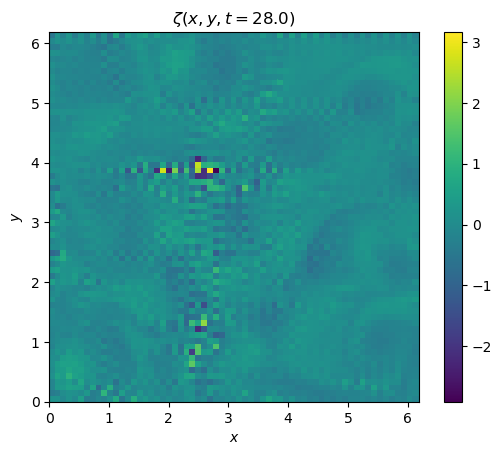

LoadError: [91mInterruptException:[39m

In [28]:
time = t[2]
zeta = real(ifft(zetah))
 psi = real(ifft(-invksq.*zetah))
maxz = maximum(abs.(zeta))
levs = linspace(-maxz, maxz, 21)

# fig, ax = subplots(ncols=1, nrows=1, figsize=(7, 4))
fig = figure()

for j = 2:nstep
    
    psih = -invksq.*zetah           # calculate \hat{ψ}
#     zeta =  real(ifft(zetah))       # calculate ζ(x,y,t)
    u = real(ifft(-im*L.*psih))     # calculate zonal velocity u(x,y,t)
    v = real(ifft(+im*K.*psih))     # calculate meridional velocity v(x,y,t)
    zetax =  real(ifft(im*K.*zetah))       # calculate \d/dx ζ(x,y,t)
    zetay =  real(ifft(im*L.*zetah))       # calculate \d/dy ζ(x,y,t)ζ(x,y,t)

    # now we are ready to calculate the r.h.s. of our PDE
    rhs = -fft(u.*zetax + v.*zetay) - nu*ksq.*zetah

    
    zetah = zetah + dt*rhs         # time-step forward using the simplest Euler scheme


    time = t[j]
    zeta = real(ifft(zetah))
     psi = real(ifft(-invksq.*zetah))
    maxz = maximum(abs.(zeta))
    levs = linspace(-maxz, maxz, 21)

    time = t[j]
    nc=4
    figure(1)
    pcolormesh(X, Y, zeta0)
    quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end], units="width")

    if j % 100 == 1
        println(j)
        time = t[j]
        zeta = real(ifft(zetah))
         psi = real(ifft(-invksq.*zetah))
        u = real(ifft(+im*L.*invksq.*zetah))     # calculate zonal velocity u(x,y,t)
        v = real(ifft(-im*K.*invksq.*zetah))     # calculate meridional velocity v(x,y,t)
        maxz = maximum(abs.(zeta))
        levs = linspace(-maxz, maxz, 21)


        pcolormesh(X, Y, zeta, animated=true)
#         quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
        title("\$\\zeta(x, y, t = $time )\$")
        xlabel(L"$x$")
        ylabel(L"$y$")
        axis("square")
        colorbar()
        sleep(0.001)
        IJulia.clear_output(true)
        display(fig)
        clf()
    end
end

Plot the final state.

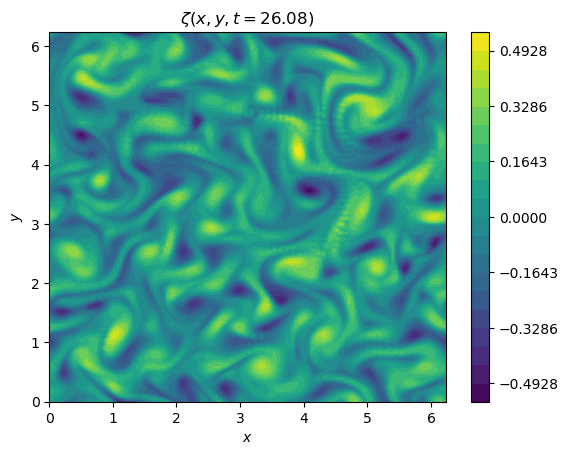

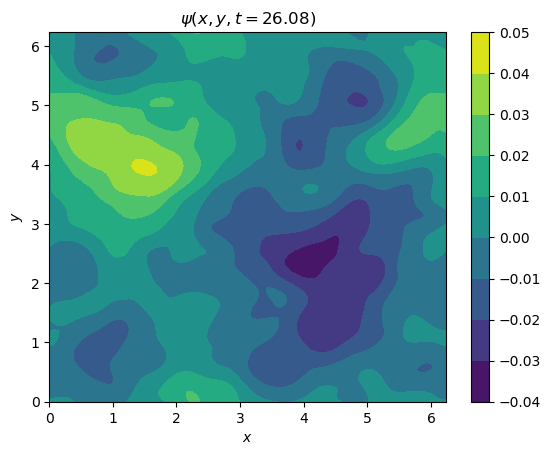

In [6]:
time = t[j]
zeta = real(ifft(zetah))
 psi = real(ifft(-invksq.*zetah))
maxz = maximum(abs.(zeta))
levs = linspace(-maxz, maxz, 21)


fig = figure(1)
contourf(X, Y, zeta, levs)
title("\$\\zeta(x, y, t = $time )\$")
xlabel(L"$x$")
ylabel(L"$y$")
draw()
colorbar();

fig = figure(2)
contourf(X, Y, psi)
title("\$\\psi(x, y, t = $time )\$")

xlabel(L"$x$")
ylabel(L"$y$")
draw()
colorbar();

**Exercise**: Improve this code so that you approach the quality of the video that Bill showed in his lecture 2. For example:

1. Try using a better time-stepping scheme. For example, Runge-Kutta 4th order, or Adams–Bashforth 3rd order, or solve for the linear dynamics (here only the $\nu \nabla^2 q$ term) explicitly using exponential integrators (e.g., [ETDRK4](https://github.com/navidcy/ETDRK4_notes)).

2. Try using higher-order viscocity so that the small wavenumber are less damped and thus  better approach the inviscid limit, for example $(-1)^{h+1}\nu \nabla^{2h} q$. (For $h=1$ this is just bare Navier-Stokes viscosity.)

3. Try implementing dealiasing in the code. Some notes on dealiasing can be found [here](http://pauli.uni-muenster.de/tp/fileadmin/lehre/NumMethoden/SS16/pseudospectral.pdf).

4. Try adding the $\beta\partial_x\psi$ term and see if you get some zonal jets.